# Utility

In [1]:
from termcolor import colored
import msgpack
import open3d as o3d
import trimesh
import point_cloud_utils as pcu  # downsampling
from IPython.display import display, Math
import numpy as np
import matplotlib.pyplot as plt

import numba
from joblib import Parallel, delayed  # multiprocessing
import multiprocessing
import copy
from scipy.ndimage.morphology import binary_dilation, binary_erosion
from scipy.spatial.transform import Rotation
import tempfile
import gmsh
import meshio
import itertools
import shutil  # file copying
import networkx as nx # graph representation
import os

from lxml import etree
from matplotlib.colors import to_hex, to_rgba

plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

print(f"open3d :{o3d.__version__}")
print(f"trimesh:{trimesh.__version__}")
print(f"numba  :{numba.__version__}")
###########################################################
from robot_utils import *
import robot_utils
# help(robot_utils)

#############################################################
robot_folder = "../../mesh/v10/"
part_names = ["body","hip","shank_front","shank_back","thigh","knee"]

open3d :0.12.0
trimesh:3.9.8
numba  :0.53.0


In [2]:
########## discretization parameters ##############
radius_poisson = float(16) # radius for the poisson sampling
# radius_poisson = float(18) # radius for the poisson sampling
radius_knn = radius_poisson*1.6
min_radius = radius_poisson*0.5
# max_nn = 28 # maximun number of neighbors for a mass point (including self)
# max_nn = int(28)
max_nn = int(20)
print(radius_knn)


# general argument
gmsh_args = (
    ("Mesh.Algorithm", 1), # 2D mesh algorithm (1: MeshAdapt, 2: Automatic, 3: Initial mesh only, 5: Delaunay, 6: Frontal-Delaunay, 7: BAMG, 8: Frontal-Delaunay for Quads, 9: Packing of Parallelograms)
    ("Mesh.Algorithm3D", 1), # 3D mesh algorithm (1: Delaunay, 3: Initial mesh only, 4: Frontal, 7: MMG3D, 9: R-tree, 10: HXT)    
    ("Mesh.MeshSizeExtendFromBoundary", 0),# Extend computation of mesh element sizes from the boundaries into the interior (for 3D Delaunay, use 1: longest or 2: shortest surface edge length)
    ("Mesh.MeshSizeFromPoints", 0),# Compute mesh element sizes from values given at geometry points, defualt:1
    ("Mesh.MeshSizeFromCurvature", 0),# Automatically compute mesh element sizes from curvature,defult:0
    ("Mesh.OptimizeNetgen",0), # Optimize the mesh using Netgen to improve the quality of tetrahedral elements
    ("Mesh.OptimizeThreshold",0.5), # Optimize the mesh using Netgen to improve the quality of tetrahedral elements
#         ("Mesh.AllowSwapAngle",30), # Threshold angle (in degrees) between faces normals under which we allow an edge swap
    ("Mesh.VolumeEdges",1), # Display edges of volume mesh
    ("Mesh.VolumeFaces",0), # Display faces of volume mesh
    ("Mesh.SurfaceFaces",1), # Display faces of surface mesh?
#     ("Mesh.Smoothing",8), # Number of smoothing steps applied to the final mesh
    ("Mesh.Smoothing",0), # Number of smoothing steps applied to the final mesh

#     ("Mesh.SmoothNormals",0), # Smooth the mesh normals? default 0
    ("Mesh.Binary",1), # Write mesh files in binary format (if possible)
    ("Mesh.MinimumCirclePoints",0), # Minimum number of nodes used to mesh circles and ellipses
    ("Mesh.MinimumCurvePoints",0), # Minimum number of points used to mesh curves other than lines, circles and ellipses
    ("Mesh.MinimumElementsPerTwoPi",0), # Minimum number of elements per 2 * Pi radians when the mesh size is adapted to the curvature    
    ("Mesh.RefineSteps",10), # Number of refinement steps in the MeshAdapt-based 2D algorithms, default:10

# #         ("Geometry.Tolerance",radius_poisson*0.5),# Geometrical tolerance,default:1e-8
#         ("Geometry.OCCFixDegenerated",1), # Fix degenerated edges/faces when importing STEP, IGES and BRep models with the OpenCASCADE kernel, defulat:0
#         ("Geometry.OCCFixSmallEdges",1), # Fix small edges when importing STEP, IGES and BRep models with the OpenCASCADE kernel, defulat:0
#         ("Geometry.OCCFixSmallFaces",1), # Fix small faces when importing STEP, IGES and BRep models with the OpenCASCADE kernel, defulat:0
# #         ("Geometry.OCCSewFaces",1), # Sew faces when importing STEP, IGES and BRep models with the OpenCASCADE kernel
# #         ("Geometry.OCCBoundsUseStl",1), # Use STL mesh for computing bounds of OpenCASCADE shapes (more accurate, but slower)

    ("General.Verbosity",0), # Level of information printed during processing (0: no information), default:5
    ("General.Terminal",0), # Should information be printed on the terminal (if available)
#         ("Mesh.RandomSeed",0), # Seed of pseudo-random number generator
#         ("Mesh.QualitySup",0.5), # Only display elements whose quality measure is smaller than QualitySup

#----------------------- 2D specific argument ------------------------------#
    ("Mesh.MeshSizeMin", radius_poisson*1.25),
    ("Mesh.MeshSizeMax", radius_poisson*1.25),
)

# 3D specific argument
gmsh_args_3d = (
    ("Mesh.MeshSizeMin", radius_poisson*1.0),
    ("Mesh.MeshSizeMax", radius_poisson*1.0),
)


# # # discretize body
# # in_file_name: str = "../../mesh/soft_body_simplified.step"
# # out_file_name: str = "../../mesh/soft_body_simplified.msh"
# in_file_name: str = "../../mesh/leg_simplified.step"
# out_file_name: str = "../../mesh/leg_simplified.msh"
# vmesh,_= generateGmsh(in_file_name,out_file_name,dim=3,gui=True)
# # print(vmesh)
# vmeshSummary(vmesh)

###########################
# show_gui = True
show_gui = False
dim = 3

25.6


# discretization

Only need to run once

--------------------body--------------------
# vertices          = 1155
# surface triangle  = 2014
# tetra             = 3848
# unique tetra edges= 6008
# unique face edges = 3021
COM                 =  [-20.934   0.317  -0.642]
COM norm            = 20.946
mean edge length    = 20.35


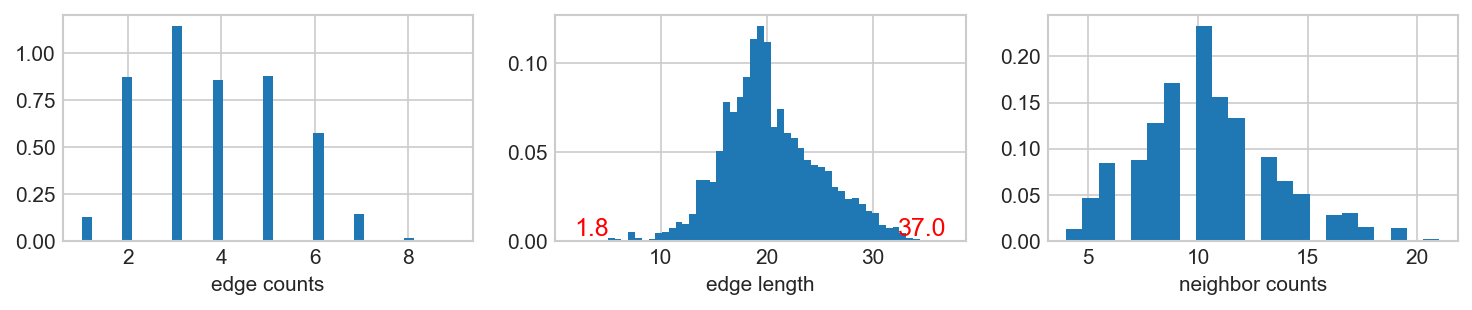

--------------------hip--------------------
# vertices          = 137
# surface triangle  = 232
# tetra             = 390
# unique tetra edges= 642
# unique face edges = 348
COM                 =  [60.337 -0.207  0.174]
COM norm            = 60.337
mean edge length    = 21.02


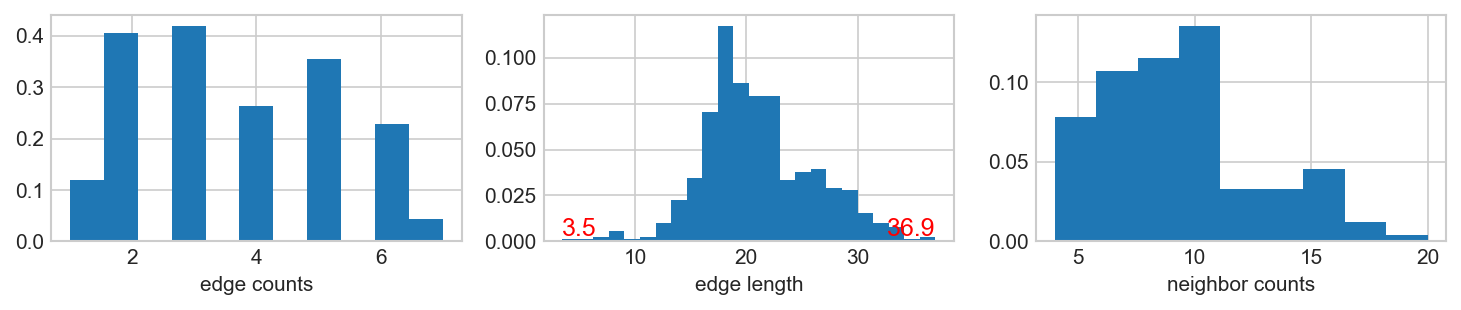

--------------------shank_front--------------------
# vertices          = 239
# surface triangle  = 398
# tetra             = 730
# unique tetra edges= 1167
# unique face edges = 597
COM                 =  [   0.097    0.044 -141.891]
COM norm            = 141.891
mean edge length    = 21.01


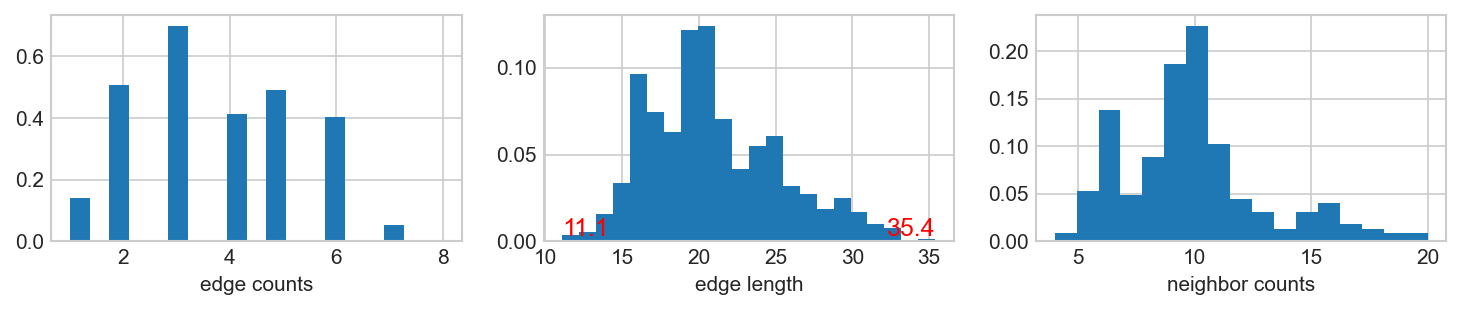

--------------------shank_back--------------------
# vertices          = 156
# surface triangle  = 284
# tetra             = 413
# unique tetra edges= 710
# unique face edges = 426
COM                 =  [ -0.808   7.497 -86.453]
COM norm            = 86.781
mean edge length    = 19.69


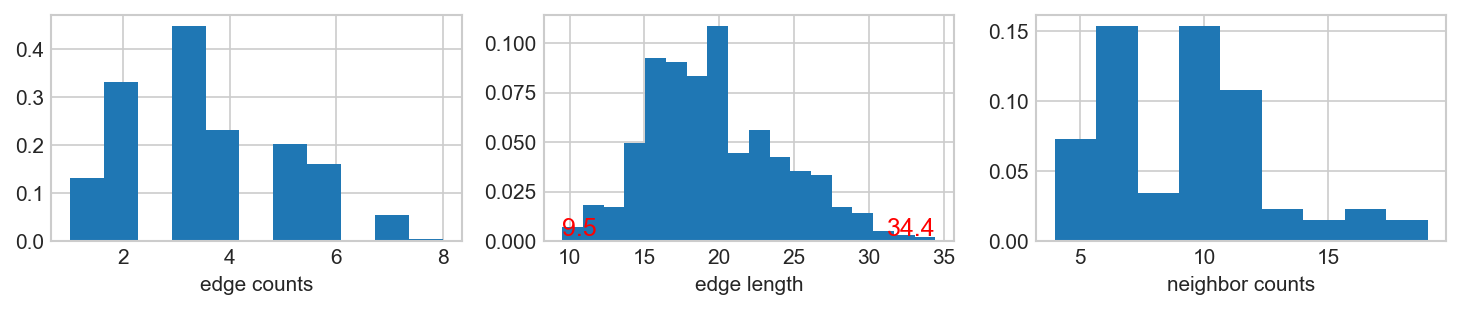

--------------------thigh--------------------
# vertices          = 181
# surface triangle  = 300
# tetra             = 544
# unique tetra edges= 874
# unique face edges = 450
COM                 =  [   0.079    0.82  -102.109]
COM norm            = 102.113
mean edge length    = 20.68


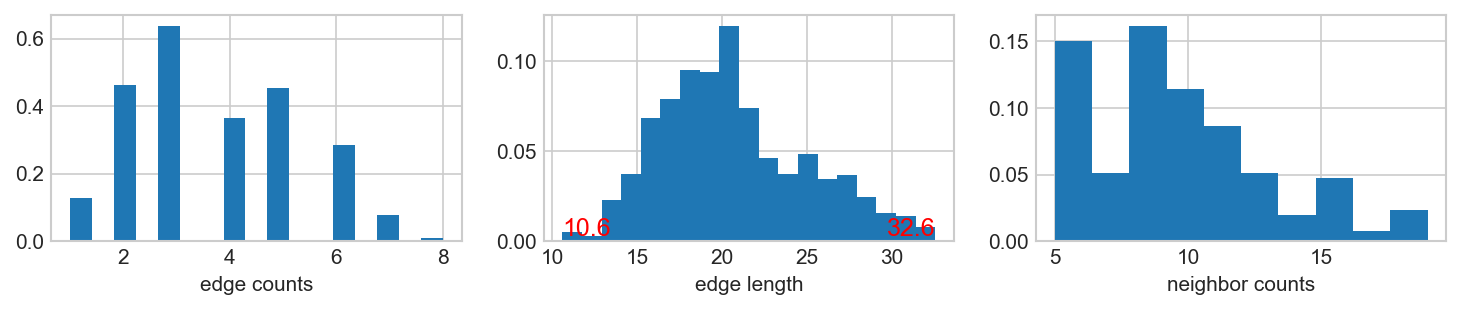

--------------------knee--------------------
# vertices          = 178
# surface triangle  = 286
# tetra             = 554
# unique tetra edges= 874
# unique face edges = 429
COM                 =  [   0.125   -0.501 -102.08 ]
COM norm            = 102.081
mean edge length    = 20.85


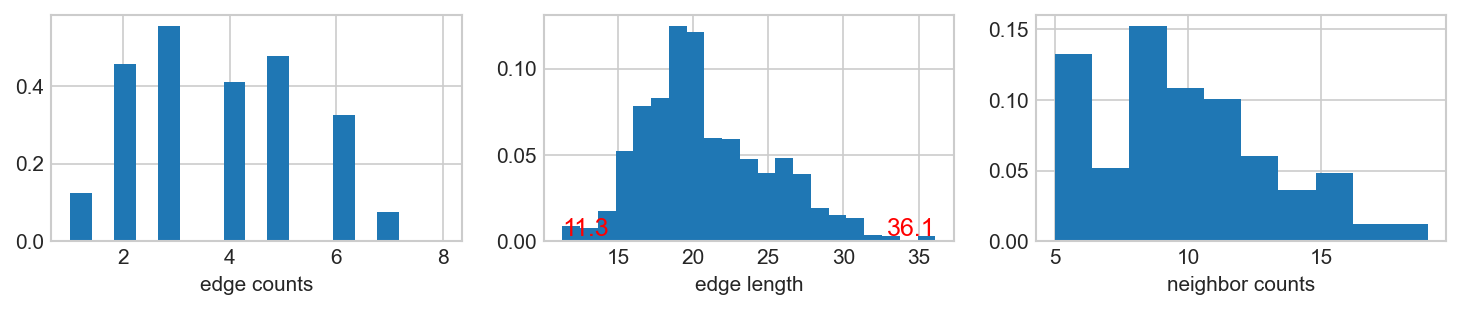

In [13]:
for part_name in part_names:
    print(f"{'-'*20}{part_name}{'-'*20}")
    in_step_file = f"{robot_folder}/{part_name}.step" # input file name
    out_msh_file = f"{robot_folder}/{part_name}.msh" # output file name for .msh
    out_stl_file = f"{robot_folder}/{part_name}.stl" # output file name for .stl
    vmesh, _ = generateGmsh(in_step_file, out_msh_file, gmsh_args=gmsh_args,
                        gmsh_args_3d=gmsh_args_3d, gui=show_gui, dim=dim)
    vmeshSummary(vmesh)
    # convert to stl
    convertStepToSTL(in_step_file,out_stl_file)

# part_name = "shank_back"
# in_step_file = f"{robot_folder}/{part_name}.step" # input file name
# out_msh_file = f"{robot_folder}/{part_name}.msh" # output file name for .msh
# out_stl_file = f"{robot_folder}/{part_name}.stl" # output file name for .stl
# vmesh, _ = generateGmsh(in_step_file, out_msh_file, gmsh_args=gmsh_args,
#                     gmsh_args_3d=gmsh_args_3d, gui=show_gui, dim=dim)
# vmeshSummary(vmesh)
# # convert to stl
# convertStepToSTL(in_step_file,out_stl_file)

# load descritized mesh

# vertices         = 1155
# lines            = 6396
# surface triangle = 2014
mean line length   = 20.68
COM                = [-20.934   0.317  -0.642]
COM norm           = 20.946


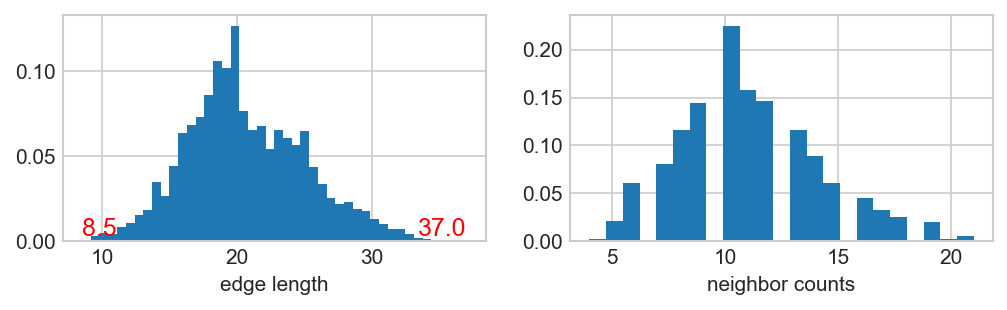

# vertices         = 137
# lines            = 663
# surface triangle = 232
mean line length   = 21.21
COM                = [60.337 -0.207  0.174]
COM norm           = 60.337


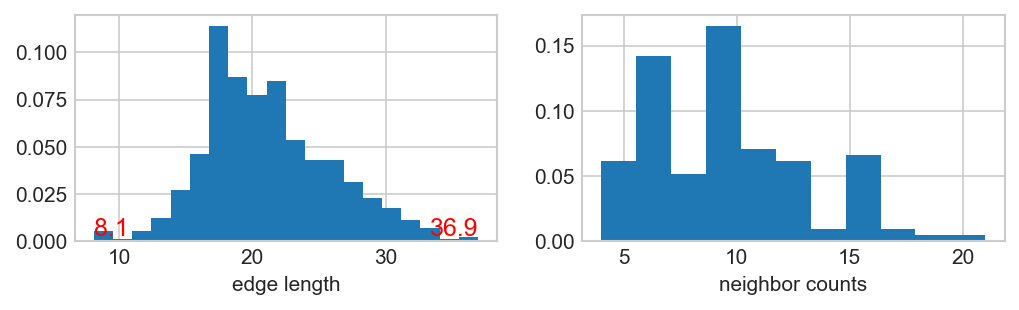

# vertices         = 239
# lines            = 1182
# surface triangle = 398
mean line length   = 21.04
COM                = [   0.097    0.044 -141.891]
COM norm           = 141.891


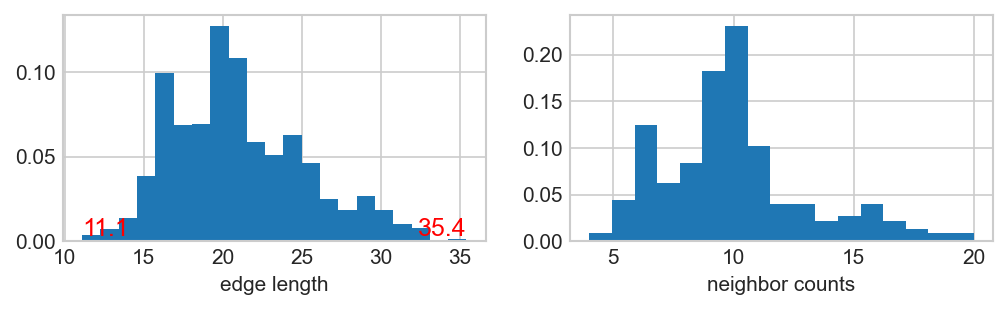

# vertices         = 156
# lines            = 748
# surface triangle = 284
mean line length   = 19.88
COM                = [ -0.808   7.497 -86.453]
COM norm           = 86.781


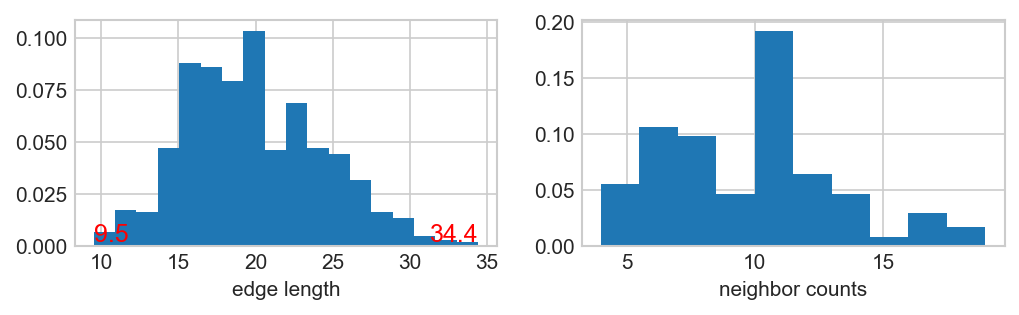

# vertices         = 181
# lines            = 892
# surface triangle = 300
mean line length   = 20.73
COM                = [   0.079    0.82  -102.109]
COM norm           = 102.113


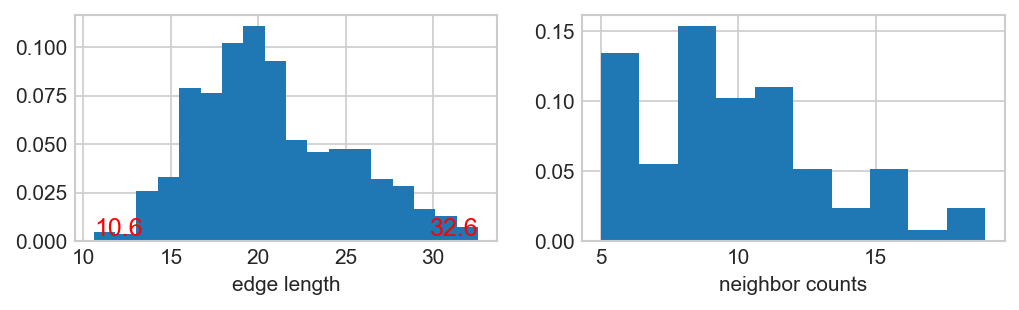

# vertices         = 178
# lines            = 892
# surface triangle = 286
mean line length   = 20.92
COM                = [   0.125   -0.501 -102.08 ]
COM norm           = 102.081


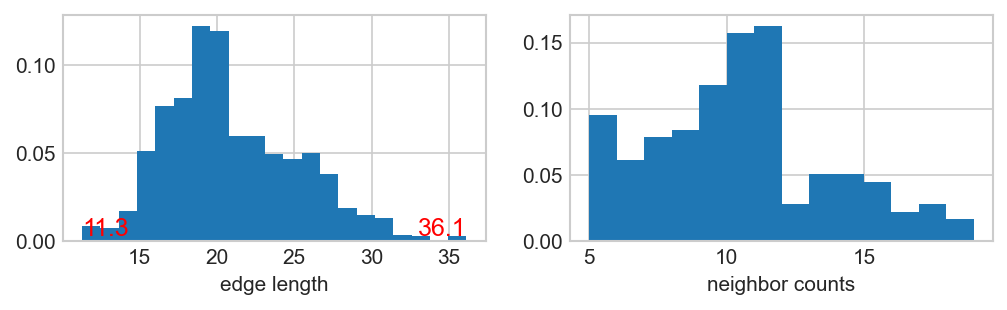

In [14]:
###############################################################
# for body:
# x: back->front
# y: right->left
# z: down->top

vmds = {name:
       VolumeMesh.fromGmsh(
    msh_file=f"{robot_folder}/{name}.msh",
    stl_file = f"{robot_folder}/{name}.stl",
    min_radius=min_radius, max_radius=radius_knn, max_nn=max_nn,transform=np.eye(4),verbose=True)
    for name in part_names
       }

In [15]:
# vmd = vmd_0.copy()
# cylinder_trimesh = trimesh.creation.cylinder(10,10)
# cylinder_trimesh.show()
# scene = trimesh.scene.Scene([trimesh.creation.cylinder(10,10),trimesh.creation.cylinder(5,20)])
# scene.show()
# vmd = VolumeMesh(vmd_leg.vertices,vmd_leg.lines,vmd_leg.triangles).copy(cmap ='pink')
# o3dShow([vmd.lsd,vmd.pcd])

In [16]:
# saving
import pickle
path = robot_folder+"parts.pickle"
with open(path,"wb") as f:
    pickle.dump(vmds,f)

In [17]:
# loading
import pickle
path = robot_folder+"parts.pickle"
with open(path,"rb") as f:
    vmds = pickle.load(f)

# Assemble the parts

In [18]:
# unit = Unit({"length":"mm","density":"g/mm^3"})
# unit.toSI("density")

In [19]:
############################ defineing joints geometry
dx_body_f0 = 48.
dy_body_f0 = 107.
dz_body_f0 = 0.

dx_f01 = 66.
dy_f01 = 0.
dz_f01 = 0.

# dx_f12 = 0.
# dy_f12 = 0.
# dz_f12 = 143.

dx_body_b0 = 153.
dy_body_b0 = 30.
dz_body_b0 = 0.

dx_b01 = 66.
dy_b01 = 0.
dz_b01 = 0.

dx_b12 = 0.
dy_b12 = 0.
dz_b12 = 120.

dx_b23 = 0.
dy_b23 = 0.
dz_b23 = 120.

#------front left --------#
tlf_b0 = np.array([
    [0,0,1,dx_body_f0],
    [1,0,0,dy_body_f0],
    [0,1,0,dz_body_f0],
    [0,0,0,1]])# front left hip

tlf_01 = np.array([
    [0,0,-1,dx_f01],
    [-1,0,0,dy_f01],
    [0,1,0,dz_f01],
    [0,0,0,1]])# front left shank 

#------front right --------#
trf_b0 = np.array([
    [0, 0,1,dx_body_f0],
    [-1,0,0,-dy_body_f0],
    [0,-1,0,dz_body_f0],
    [0,0,0,1]])# front right hip

trf_01 = np.array([
    [0,0,-1,dx_f01],
    [1,0,0,dy_f01],
    [0,-1,0,dz_f01],
    [0,0,0,1]])# front right shank 

#------back left --------#
tlb_b0 = np.array([
    [0,0,1,-dx_body_b0],
    [1,0,0,dy_body_b0],
    [0,1,0,dz_body_b0],
    [0,0,0,1]])# back left hip

tlb_01 = np.array([
    [0, 0,-1,dx_b01],
    [-1,0, 0,dy_b01],
    [0, 1, 0,dz_b01],
    [0,0,0,1]])# back left thigh 

tlb_12 = np.array([
    [0, 1, 0,dx_b12],
    [-1,0, 0,dy_b12],
    [0, 0, 1,-dz_b12],
    [0,0,0,1]])# back left knee 

tlb_23 = np.array([
    [1, 0, 0,dx_b23],
    [0, 1, 0,dy_b23],
    [0, 0, 1,-dz_b23],
    [0,0,0,1]])# back left shank 

#------back right --------#
trb_b0 = np.array([
    [0, 0,1,-dx_body_b0],
    [-1,0,0,-dy_body_b0],
    [0,-1,0,dz_body_b0],
    [0,0,0,1]])# back right hip

trb_01 = np.array([
    [0, 0,-1,dx_b01],
    [1, 0, 0,dy_b01],
    [0,-1, 0,dz_b01],
    [0,0,0,1]])# back right thigh 

trb_12 = np.array([
    [0,-1, 0,dx_b12],
    [1, 0, 0,dy_b12],
    [0, 0, 1,-dz_b12],
    [0,0,0,1]])# back right knee 

trb_23 = np.array([
    [1, 0, 0,dx_b23],
    [0, 1, 0,dy_b23],
    [0, 0, 1,-dz_b23],
    [0,0,0,1]])# back right shank 

In [20]:
PI = np.pi

graph = RobotDescription(unit_dict={"length": "mm"})
graph.add_nodes_from([
    (0, {"vmd": vmds["body"].copy(         cmap='RdGy'), "alias": "body","color":to_rgba("r")}),  # main_body # 
    (1, {"vmd": vmds["hip"].copy(        cmap='spring'), "alias": "lf_hip","color":to_rgba("g")}),  # front left
    (2, {"vmd": vmds["shank_front"].copy(cmap='spring'), "alias": "lf_shank","color":to_rgba("b")}),

    (3, {"vmd": vmds["hip"].copy(        cmap='summer'), "alias": "rf_hip","color":to_rgba("g")}),  # front right
    (4, {"vmd": vmds["shank_front"].copy(cmap='summer'), "alias": "rf_shank","color":to_rgba("b")}),

    (5, {"vmd": vmds["hip"].copy(        cmap='autumn'), "alias": "lb_hip","color":to_rgba("g")}),  # back left
    (6, {"vmd": vmds["thigh"].copy(      cmap='autumn'), "alias": "lb_thigh","color":to_rgba("b")}),
    (7, {"vmd": vmds["knee"].copy(       cmap='autumn'), "alias": "lb_knee","color":to_rgba("g")}),
    (8, {"vmd": vmds["shank_back"].copy( cmap='autumn'), "alias": "lb_shank","color":to_rgba("b")}),

    (9, {"vmd": vmds["hip"].copy(        cmap='winter'), "alias": "rb_hip","color":to_rgba("g")}),  # back right
    (10,{"vmd": vmds["thigh"].copy(      cmap='winter'), "alias": "rb_thigh","color":to_rgba("b")}),
    (11,{"vmd": vmds["knee"].copy(       cmap='winter'), "alias": "rb_knee","color":to_rgba("g")}),
    (12,{"vmd": vmds["shank_back"].copy( cmap='winter')\
          .transform(axisAngleRotation((0, 0, 1),PI))# rotate 180 deg around local z axis
         , "alias": "rb_shank","color":to_rgba("b")}),
],
    transform=np.eye(4),
    density=176.,
    color=np.array((1, 1, 1, 1))  # white
)
#graph.nodes['body']['density'] = 100

graph.add_edges_from((
    (0, 1, {"order":0,"transform": tlf_b0, "joint_pos": 0,"limit":{"lower":-PI,"upper":PI}}),
    (1, 2, {"order":1,"transform": tlf_01, "joint_pos": 0,"limit":{"lower":-5/9*PI,"upper":5/9*PI}}),

    (0, 3, {"order":2,"transform": trf_b0, "joint_pos": 0,"limit":{"lower":-PI,"upper":PI}}),
    (3, 4, {"order":3,"transform": trf_01, "joint_pos": 0,"limit":{"lower":-5/9*PI,"upper":5/9*PI}}),

    (0, 5, {"order":4,"transform": tlb_b0, "joint_pos": 0,"limit":{"lower":-PI,"upper":PI}}),
    (5, 6, {"order":5,"transform": tlb_01, "joint_pos": 0,"limit":{"lower":-5/9*PI,"upper":5/9*PI}}),
    (6, 7, {"order":6,"transform": tlb_12, "joint_pos": 0,"limit":{"lower":-0.5*PI,"upper":0.5*PI}}),
    (7, 8, {"order":7,"transform": tlb_23, "joint_pos": 0,"limit":{"lower":-0.5*PI,"upper":0.5*PI}}),

    (0, 9, {"order":8,"transform": trb_b0, "joint_pos": 0,"limit":{"lower":-PI,"upper":PI}}),
    (9, 10, {"order":9,"transform": trb_01, "joint_pos": 0,"limit":{"lower":-5/9*PI,"upper":5/9*PI}}),
    (10, 11, {"order":10,"transform": trb_12, "joint_pos": 0,"limit":{"lower":-0.5*PI,"upper":0.5*PI}}),
    (11, 12, {"order":11,"transform": trb_23, "joint_pos": 0,"limit":{"lower":-0.5*PI,"upper":0.5*PI}}),

),
    transform=np.eye(4),
    joint_type="revolute",
    joint_pos=0,
    axis=(1, 0, 0),
    limit={  # units must be SI here
        "effort": 11,  # torque, [Nm]
        "velocity": round(487/60*2*PI)  # speed [rad/s]
}
)

# create coordinate in body space
graph.createCoordinateOXYZ(radius=15)
################## computed value ###################################
graph.updateWorldTransform(t = axisAngleRotation((0, 1, 0),-np.pi/2)) # standing orientation
# graph.updateWorldTransform() # quraduped orientation


# list(nx.edge_bfs(graph))

#####################################################################
for k, e in enumerate(graph.orderedEdges):
    print(f"{k}:{e}")
# graph.draw()

####################################################################
# print(graph.nodes[0]["vmd"].vertices.shape,graph.nodes[0]["vmd"].lines.shape)
# o3dShow(graph.nodes[0]["vmd"].lsd(),background_color=(0,0,0))


# world_space_pcds = [o3d.geometry.PointCloud(graph.nodes[n]["vmd"].pcd()).transform(
#     graph.nodes[n]["world_transform"]) for n in graph.nodes]
# world_space_lsd = [o3d.geometry.LineSet(graph.nodes[n]["vmd"].lsd()).transform(
#     graph.nodes[n]["world_transform"]) for n in graph.nodes]
# o3dShow(world_space_pcds+world_space_lsd+[coord_frame])


0:(0, 1)
1:(1, 2)
2:(0, 3)
3:(3, 4)
4:(0, 5)
5:(5, 6)
6:(6, 7)
7:(7, 8)
8:(0, 9)
9:(9, 10)
10:(10, 11)
11:(11, 12)


In [21]:
pi = np.pi

p_f01 = pi/4 # front arm 01

p_bb0 = pi/12
p_b23 = pi/12
p_b12 = p_bb0+p_b23

graph.joint_pos = np.array([
# front left
    0,
    -p_f01,
# front right
    0,
    p_f01,
# back left
    -p_bb0,
    -pi/2,
    -p_b12,
     p_b23,
#back right
     p_bb0,
     pi/2,
     p_b12,
    -p_b23,

])


# graph.updateWorldTransform(t = axisAngleRotation((0, 0, 1),np.pi/2)) #TODO MAKE IT RIGHT
graph.updateWorldTransform()

world_space_pcds = [o3d.geometry.PointCloud(graph.nodes[n]["vmd"].pcd()).transform(
    graph.nodes[n]["world_transform"]) for n in graph.nodes]

world_space_lsd = [o3d.geometry.LineSet(graph.nodes[n]["vmd"].lsd()).transform(
    graph.nodes[n]["world_transform"]) for n in graph.nodes]

world_space_o3dMesh = [o3d.geometry.TriangleMesh(graph.nodes[n]["vmd"].o3dMesh()).transform(
    graph.nodes[n]["world_transform"]) for n in graph.nodes]



link_coordinate_frames = [o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=50).transform(graph.nodes[n]["world_transform"])for n in graph.nodes]

joint_coordiate_frams = [o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=50).transform(graph.edges[e]["world_transform"])for e in graph.edges]

# o3dShow(world_space_pcds+world_space_lsd+link_coordinate_frames+joint_coordiate_frams + [coord_frame],background_color=(0,0,0))


###############################################
discretization_opt = dict(
    radius_poisson = radius_poisson,
    min_radius=min_radius,
    max_radius=radius_knn, 
    max_nn=max_nn,
    joint_radius = 35.,
    joint_height = 50.,
    gmsh_args=gmsh_args,
    gmsh_args_3d=gmsh_args_3d,
)


graph = graph.makeJoint(opt=discretization_opt)
#################################################

joint_cylinders = [o3d.geometry.TriangleMesh(graph.edges[e]["cylinder_parent"].o3dMesh()).transform(
    graph.nodes[e[0]]["world_transform"]) for e in graph.edges]
# o3dShow(world_space_pcds[0:]+world_space_lsd[0:]+world_space_o3dMesh[0:]+joint_cylinders[0:])#+link_coordinate_frames+joint_coordiate_frams)
# o3dShow([coord_frame.translate((0,0,0))]+world_space_pcds[0:]+world_space_lsd[0:]+joint_coordiate_frams+link_coordinate_frames+joint_cylinders[0:],background_color=(0,0,0))#+link_coordinate_frames+joint_coordiate_frams)

o3dShow(world_space_pcds+world_space_lsd + [coord_frame])#+link_coordinate_frames+joint_coordiate_frams)


# robot_lsd = o3d.geometry.LineSet(
#     o3d.utility.Vector3dVector(vertices),
#     o3d.utility.Vector2iVector(lines))
# robot_lsd.colors = o3d.utility.Vector3dVector(colors[lines].mean(axis=1))
# o3dShow([robot_lsd]+joint_cylinders[0:])


# o3dShow(o3d.geometry.LineSet(
#     o3d.utility.Vector3dVector(graph.nodes[0]["vmd"]["vertices"]),
#     o3d.utility.Vector2iVector(graph.nodes[0]["vmd"]["lines"])), background_color=(1, 1, 1)
# )

# # saving
# import pickle
# path = robot_folder+"robot.pickle"
# with open(path,"wb") as f:
#     pickle.dump(graph,f)
    
# # loading
# import pickle
# path = robot_folder+"robot.pickle"
# with open(path,"rb") as f:
#     graph = pickle.load(f)

(0, 1):59,59
(0, 3):59,59
(0, 5):59,59
(0, 9):59,59
(1, 2):59,59
(3, 4):59,59
(5, 6):59,59
(6, 7):59,59
(7, 8):59,59
(9, 10):59,59
(10, 11):59,59
(11, 12):59,59


# create spring-mass representation

dict_id2node=
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12}
dict_id2edge=
{0: (0, 1), 1: (0, 3), 2: (0, 5), 3: (0, 9), 4: (1, 2), 5: (3, 4), 6: (5, 6), 7: (6, 7), 8: (7, 8), 9: (9, 10), 10: (10, 11), 11: (11, 12)}
----------------------------------------
id_vertices:
label           length  indices
part            4400    [   0 1334 1570 1868 2104 2402 2638 2914 3186 3401 3637 3913 4185 4400]
anchor          24      [4400 4402 4404 4406 4408 4410 4412 4414 4416 4418 4420 4422 4424]
part_coord      78      [4424 4430 4436 4442 4448 4454 4460 4466 4472 4478 4484 4490 4496 4502]
joint_coord     72      [4502 4508 4514 4520 4526 4532 4538 4544 4550 4556 4562 4568 4574]
----------------------------------------
id_lines:
label           length  indices
part            27501   [    0  8837 10522 12065 13752 15294 16983 18617 20277 21395 23083 24720
                         26381 27501]
anchor          12      [27501 27502 27503 27504 27505 27506 27507 27

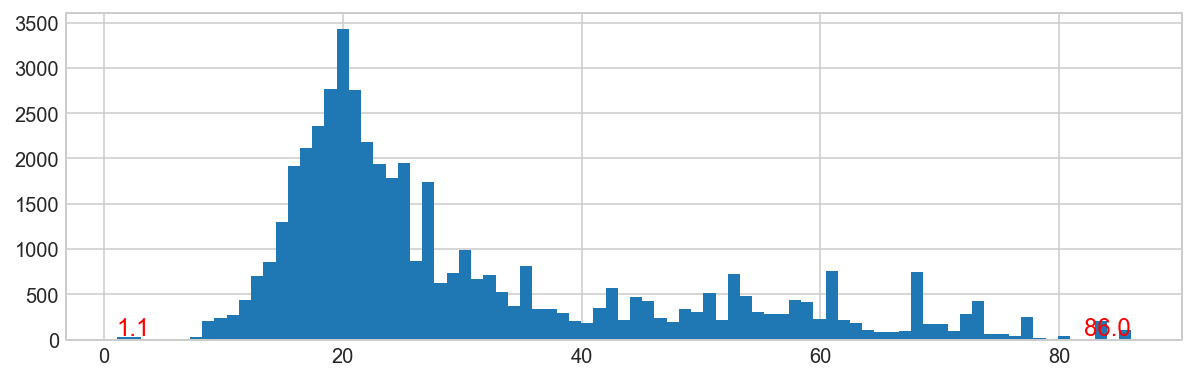

In [22]:
# number of attachment lines per point in the attached coordinates
# num_attach_per_coord = 20
num_attach_per_coord = 20

# num of friction spring (spring connecting the two parts of the joint) per mass
# num_fri_spring_per_mass = 20
num_fri_spring_per_mass = 20

######################################################################
dict_id2node = dict(enumerate(graph.nodes)) # dict of index to node
dict_node2id = dict(zip(graph.nodes, range(len(graph.nodes)))) # dict of node to index
print(f"dict_id2node=\n{dict_id2node}")
dict_id2edge = dict(enumerate(graph.edges)) # dict of index to edges
dict_edge2id = dict(zip(graph.edges, range(len(graph.edges))))
print(f"dict_id2edge=\n{dict_id2edge}","-"*40, sep = "\n")


graph.updateWorldTransform()

# ############################# transform vertices local to world ############
part_vertices = [applyTransform(graph.nodes[n]["vmd"].vertices,
                                graph.nodes[n]["world_transform"]) for n in graph.nodes]
anchor_vertices = [applyTransform(graph.edges[e]['anchor'],
                                  graph.edges[e]["world_transform"]) for e in graph.orderedEdges]
part_coord_vertices = [applyTransform(graph.nodes[n]['coord'],
                                      graph.nodes[n]["world_transform"]) for n in graph.nodes]
joint_coord_vertices = [applyTransform(graph.edges[e]['coord'],
                                       graph.edges[e]["world_transform"]) for e in graph.orderedEdges]


vertices, id_vertices = flattenNamedArrays((
    ("part", part_vertices),
    ("anchor", anchor_vertices),
    ("part_coord", part_coord_vertices),
    ("joint_coord", joint_coord_vertices)),dim=3)

# colors of the vertices
part_colors = np.vstack([graph.nodes[n]["vmd"]["vertices_color"] for n in graph.nodes])
colors = np.zeros((len(vertices), 3))
colors[:len(part_colors)] = part_colors

###################################################################
vid_part = id_vertices["part"]
vid_anchor = id_vertices["anchor"]
vid_part_coord = id_vertices["part_coord"]
vid_joint_coord = id_vertices["joint_coord"]

for k, n in enumerate(graph.nodes):
    graph.nodes[n]["vertex_start_id"] = vid_part[k]
    graph.nodes[n]["coord_start_id"] = vid_part_coord[k]
for k, e in enumerate(graph.orderedEdges):
    graph.edges[e]["coord_start_id"] = vid_joint_coord[k]
    graph.edges[e]["anchor_start_id"] = vid_anchor[k]
############################################################
part_triangles = [graph.nodes[n]["vmd"].triangles +
              graph.nodes[n]["vertex_start_id"] for n in graph.nodes]

triangles = np.vstack(part_triangles)
###############################################################
# part surfaces
part_surface_id = np.unique(triangles)
is_surface = np.zeros(len(vertices), dtype=bool)
is_surface[part_surface_id] = True
###############################################################
# lines
part_lines = [graph.nodes[n]["vmd"].lines +
              graph.nodes[n]["vertex_start_id"] for n in graph.nodes]

anchor_lines = [(graph.edges[e]["anchor_start_id"],
                 graph.edges[e]["anchor_start_id"]+1) for e in graph.orderedEdges]

part_coord_self_lines = [graph.nodes[n]["coord_start_id"] +
                         graph.nodes[n]["coord_self_lines"] for n in graph.nodes]
joint_coord_self_lines = [graph.edges[e]["coord_start_id"] +
                          graph.edges[e]["coord_self_lines"] for e in graph.orderedEdges]


# connecting coordinate to the body parts
part_coord_attach_lines = []
for k, n in enumerate(graph.nodes):
    part_coord_attach_lines.append(
        joinLines(left_vertices=part_vertices[k],
                  right_vertices=part_coord_vertices[k],
                  max_nn=num_attach_per_coord, min_radius=min_radius, max_radius=radius_knn*10,
                  left_id_start=vid_part[k],
                  right_id_start=vid_part_coord[k]))

# connecting coordinate to the joint-parent
joint_coord_attach_lines = []
for k, e in enumerate(graph.orderedEdges):
    parent_id = dict_node2id[e[0]]
    joint_coord_attach_lines.append(
        joinLines(left_vertices=part_vertices[parent_id],  # parent vertices
                  right_vertices=joint_coord_vertices[k],
                  max_nn=num_attach_per_coord, min_radius=min_radius, max_radius=radius_knn*10,
                  left_id_start=vid_part[parent_id],
                  right_id_start=vid_joint_coord[k]))


joints = []

for k, e in enumerate(graph.orderedEdges):
    edge = graph.edges[e]
    parent = e[0]
    child = e[1]
    parent_id = dict_node2id[e[0]]
    child_id = dict_node2id[e[1]]
    left = edge["id_joint_parent"]+vid_part[parent_id]
    right = edge["id_joint_child"]+vid_part[child_id]
    joint_k = Joint(
        left=left, # indices of the left mass
        right=right, # indices of the right mass
        vertices=vertices, # flattened array of vertices
        anchor=anchor_lines[k], # anchoring points (index) for the joint
        left_coord=edge["coord_start_id"],  # start id of the left coordinate
        right_coord=graph.nodes[child]["coord_start_id"], # start id of the right coordinate (child)
        min_radius = min_radius*0.5,
        num_spring_per_mass = num_fri_spring_per_mass,
        axis=edge["axis"]
    )
    joints.append(joint_k)

rot_springs = [j.rot_spring for j in joints]
fri_springs = [j.fri_spring for j in joints]


# lines:
# parts_lines = part_k_lines for k in range(#nodes)
# anchors_lines
# oxyz_self_springs
# oxyz_anchor_springs
# rotation springs
# resetable friction springs

coord_self_lines = part_coord_self_lines+joint_coord_self_lines
coord_attach_lines = part_coord_attach_lines+joint_coord_attach_lines

lines,id_lines = flattenNamedArrays((
    ("part",part_lines),
    ("anchor",anchor_lines),
    ("rot_spring",rot_springs),
    ("fri_spring",fri_springs),
    ("coord",coord_self_lines),
    ("coord_attach",coord_attach_lines)),dim=2)

# whether the springs has surface end-points
lines_is_surface = np.bitwise_or.reduce(np.isin(lines,part_surface_id),1)

########################## print info #################################################
######## print id_vertices
print("id_vertices:")
print(f"{'label':16s}{'length':8s}{'indices'}")
for label,ids in id_vertices.items():
    print(f"{label:16s}{ids[-1]-ids[0]:<8d}{ids}".replace('\n', '\n'+' '*24))
print("-"*40)

######## print id_lines
print("id_lines:")
print(f"{'label':16s}{'length':8s}{'indices'}")
for label,ids in id_lines.items():
    print(f"{label:16s}{ids[-1]-ids[0]:<8d}{ids}".replace('\n', '\n'+' '*24))
print("-"*40)

lines_length = np.linalg.norm(vertices[lines[:,0]] - vertices[lines[:,1]],axis=1)
plt.figure(figsize=(10,3))
n,bins,_ =plt.hist(lines_length,bins="auto")
plt.text(bins[0],0,f"{bins[0]:.1f}",ha="left",va="bottom",fontsize="large",color='r')
plt.text(bins[-1],0,f"{bins[-1]:.1f}",ha="right",va="bottom",fontsize="large",color='r')

plt.show()

In [23]:
# joint_radius = 40.
# joint_height = 40.

# cylinder_spec = dict(center=(0, 0, 0), axis=(1, 0, 0),
#                      radius=joint_radius, height=joint_height)
# cyliner_k, _ = generateGmsh(gmshGeoFcn=gmshGeoAddCylinder, gmsh_geo_kwargs=cylinder_spec,
#                             gmsh_args=gmsh_args+gmsh_args_3d, gmsh_args_3d={}, gui=True)

# vmd_cylinder = VolumeMesh.fromGmsh(
#             cyliner_k, min_radius=min_radius, max_radius=radius_knn, max_nn=max_nn)
# o3dShow([vmd_cylinder.lsd(),vmd_cylinder.pcd(),vmd_cylinder.o3dMesh(),coord_frame])

In [24]:
num_body = len(graph.nodes)
joint_vertex_id = np.sort(np.stack([(j.left,j.right) for j in joints]).ravel())
# lines connected to joints
lines_is_joint = np.bitwise_or.reduce(np.isin(lines,joint_vertex_id),1)
# lines parts only
lines_is_part = np.zeros(len(lines),dtype=bool)
lines_is_part[id_lines["part"][1]:id_lines["part"][-1]] = True
# selected sensor lines (bool)
# lines_selected = ~lines_is_surface  * lines_is_part* ~lines_is_joint #bone
# lines_selected = lines_is_surface  * lines_is_part* ~lines_is_joint # skin
lines_selected = lines_is_part* ~lines_is_joint # all


####################################################
robot_lsd = o3d.geometry.LineSet(
    o3d.utility.Vector3dVector(vertices),
    o3d.utility.Vector2iVector(lines))
robot_lsd.colors = o3d.utility.Vector3dVector(colors[lines].mean(axis=1))

############# selected edges #########################
# robot_lsd.paint_uniform_color((0.1,0.1,0.1))
# colors = np.asarray(robot_lsd.colors)
# # colors[np.logical_not(lines_is_surface)] = (1,1,1)
# colors[lines_selected] = (1,1,1)
# colors[lines_is_joint] = (1,0,0)
# robot_lsd.colors = o3d.utility.Vector3dVector(colors)
#######################################################
# robot_lsd.paint_uniform_color((0.1,0.1,0.1))
# step =  (id_lines[num_body])//128
# colors = np.asarray(robot_lsd.colors)
# colors[np.logical_not(lines_is_surface)] = (0.2,0.2,0.2)
# colors[range(0,id_lines[num_body],step)] = (1,1,1)
# robot_lsd.colors = o3d.utility.Vector3dVector(colors)

# o3dShow([robot_lsd,coord_frame],background_color=(0,0,0))

In [25]:
# o3dShow(robot_lsd)
# export
xyz_all_trans = vertices.copy()

# xyz_all_trans = applyTransform(xyz_all_trans,axisAngleRotation((0, 1, 0),-np.pi/2))

min_bound = xyz_all_trans.min(axis=0)
# transoformed ofset scaled mm->m
xyz_all_trans = (xyz_all_trans + np.array([0, 0, 0-min_bound[-1]+-1]))/1000
# xyz_all_trans = (xyz_all_trans + np.array([0, 0, 0-min_bound[-1]]))/1000
# xyz_all_trans = (xyz_all_trans + np.array([0, 0, 0-min_bound[-1]+200]))/1000


joints_list = [joint.toDict() for joint in joints]
data = {
    "radius_poisson":radius_poisson*1e-3,# convert to m
    "vertices":xyz_all_trans.tolist(),
    "edges":lines.tolist(),
    "triangles":triangles.tolist(),
    "is_surface":is_surface.tolist(),
    "id_vertices":{key:arr.tolist() for key,arr in id_vertices.items()},
    "id_edges":{key:arr.tolist() for key,arr in id_lines.items()},
    "colors":colors.tolist(),
    "joints":joints_list,
#     "is_surface_edges":lines_is_surface.tolist(), # surface lines
    "id_selected_edges":np.flatnonzero(lines_selected).tolist() # selected edges for spring strain
}



print(xyz_all_trans.min(axis=0))
print(xyz_all_trans.max(axis=0))
print(xyz_all_trans.shape)
print(lines.shape)


robot_lsd = o3d.geometry.LineSet(
    o3d.utility.Vector3dVector(xyz_all_trans),
    o3d.utility.Vector2iVector(lines))
robot_lsd.colors = o3d.utility.Vector3dVector(colors[lines].mean(axis=1))
o3dShow([robot_lsd,o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.1, origin=[0, 0, 0])])

# https://stackoverflow.com/questions/43442194/how-do-i-read-and-write-with-msgpack
# Write msgpack file
with open('../flexipod_12dof.msgpack', 'wb') as outfile:
    msgpack.pack(data, outfile)
    
# # Read msgpack file
# with open('../flexipod_12dof.msgpack','rb') as data_file:
#     # data_loaded = json.load(data_file)
#     data_loaded = msgpack.unpack(data_file)

[-0.047      -0.36530584 -0.001     ]
[0.0769841  0.36530584 0.6038222 ]
(4574, 3)
(47880, 2)


##  generate URDF

In [17]:
urdf_path = "../../data/urdf/12dof/robot.urdf"
graph.exportURDF(path= urdf_path,use_fine_mesh=True)

URDF path:D:\repo\FlexipodFast\data\urdf\12dof\robot.urdf

<?xml version='1.0' encoding='ASCII'?>
<robot name="robot">
  <link name="0">
    <inertial>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <mass value="0.6982204026089079"/>
      <inertia ixx="0.0027568162609792027" ixy="-0.0" ixz="4.3035096179499014e-05" iyy="0.00819108785451" iyz="4.969259957225228e-21" izz="0.0098023652972453"/>
    </inertial>
    <visual>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <geometry>
        <mesh filename="mesh/0.obj"/>
      </geometry>
      <material name="#ff0000ff">
        <color rgba="1.0 0.0 0.0 1"/>
      </material>
    </visual>
    <collision>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <geometry>
        <mesh filename="mesh/0.obj"/>
      </geometry>
    </collision>
  </link>
  <link name="1">
    <inertial>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <mass value="0.07174383694960039"/>
      <inertia ixx="5.842334881129862e-05

# VHACD

In [72]:
import glob
import pybullet as p
import os
from joblib import Parallel, delayed
import shutil

def vhacd(name_in,name_out):
    physicsClientId = p.connect(p.DIRECT)
    p.vhacd(name_in, name_out, "", concavity=0.00005, resolution=8000000, 
        maxNumVerticesPerCH=256, depth=32,planeDownsampling=4,convexhullDownsampling=4,
            minVolumePerCH =0.00001,
           physicsClientId = physicsClientId)
    p.disconnect(physicsClientId)
    
urdf_dir = "../../data/urdf/12dof"
mesh_dir = f"{urdf_dir}/mesh"
mesh_original_dir = f"{urdf_dir}/mesh/original"

if not os.path.exists(mesh_original_dir):
    print("moving original mesh to 'mesh/original/'")
    os.mkdir(mesh_original_dir)

for obj_file in glob.glob(f"{mesh_dir}/*.obj"):
    base_name = os.path.basename(obj_file)
    shutil.move(obj_file,f"{mesh_original_dir}/{base_name}")
original_obj_list = glob.glob(f"{mesh_original_dir}/*.obj")
converted_obj_list = [f"{mesh_dir}/{os.path.basename(obj)}" for obj in original_obj_list]

In [73]:
n_jobs = int(min(os.cpu_count()*0.8,len(original_obj_list)))
_=Parallel(n_jobs = n_jobs,verbose=1)(
    delayed(vhacd)(n_in,n_out) for n_in,n_out in zip(original_obj_list,converted_obj_list))

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done   2 out of  13 | elapsed:    3.6s remaining:   20.1s
[Parallel(n_jobs=13)]: Done  13 out of  13 | elapsed:  1.5min finished


In [56]:
# k = 1
# name_in = original_obj_list[k]
# name_out = converted_obj_list[k]
# vhacd(name_in,name_out)

# # check the file
# name_out = os.path.abspath(name_out)
# ! $name_out

# check pybullet

In [21]:
import numpy as np
import pybullet as p
import time
import pybullet_data
from scipy.spatial.transform import Rotation

##########################################
urdf_path = "../../data/urdf/12dof/robot.urdf"
####################################################
use_fixed_base=0

gui = p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation(physicsClientId=gui)
p.setGravity(0, 0, -10)
# robot_id = p.loadURDF(urdf_path, [0, 0, 0.5], physicsClientId=gui,useFixedBase=1,flags = p.URDF_USE_SELF_COLLISION)
robot_id = p.loadURDF(urdf_path, [0, 0, 0.5], physicsClientId=gui,useFixedBase=use_fixed_base,flags = p.URDF_USE_SELF_COLLISION)

plane = p.loadURDF("plane.urdf")

# quat = Rotation.from_euler('xyz',[0,-np.pi/2,0]).as_quat()
# p.resetBasePositionAndOrientation(robot_id, [0, 0, 0.5], quat)

# # ##################################################
while (p.getConnectionInfo(physicsClientId=gui)["isConnected"]):
    #p.setJointMotorControlArray(robot_id,np.arange(p.getNumJoints(robot_id)),p.POSITION_CONTROL,joint_pos)
    p.stepSimulation(physicsClientId=gui)
    #time.sleep(0.01)
    
# p.disconnect()

In [22]:
p.disconnect()

error: Not connected to physics server.

In [ ]:
import numpy as np
import pybullet as p
import time
import pybullet_data
from scipy.spatial.transform import Rotation

##########################################
urdf_path = "../../data/urdf/12dof/robot.urdf"
####################################################
use_fixed_base=0

gui = p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation(physicsClientId=gui)
p.setGravity(0, 0, -10)
# robot_id = p.loadURDF(urdf_path, [0, 0, 0.5], physicsClientId=gui,useFixedBase=1,flags = p.URDF_USE_SELF_COLLISION)
robot_id = p.loadURDF(urdf_path, [0, 0, 0.5], physicsClientId=gui,useFixedBase=use_fixed_base,flags = p.URDF_USE_SELF_COLLISION)

plane = p.loadURDF("plane.urdf")


joint_pos = np.array([
    # front left
    -np.pi/2,               # 0
    -np.pi/2,        # 1
    0,               # 2
    # front right
    np.pi/2,               # 3 
    np.pi/2,         # 4  
    0,               # 5
    # back left
    -np.pi/2,               # 6     
    -np.pi/2,        # 7   
    0,               # 8
    # back right
    np.pi/2,               # 9        
    np.pi/2,         # 10 
    0                # 11   
]) 
dof = len(joint_pos)
for k in range(dof):
    p.resetJointState(robot_id, k, targetValue=joint_pos[k])
    
# quat = Rotation.from_euler('xyz',[0,-np.pi/2,0]).as_quat()
# p.resetBasePositionAndOrientation(robot_id, [0, 0, 0.5], quat)

p.setJointMotorControlArray(robot_id, list(range(dof)), controlMode= p.POSITION_CONTROL,
                                    targetPositions=joint_pos)
# for k in range(1000):
#     p.stepSimulation(physicsClientId=gui)
    
# # ##################################################
while (p.getConnectionInfo(physicsClientId=gui)["isConnected"]):
    #p.setJointMotorControlArray(robot_id,np.arange(p.getNumJoints(robot_id)),p.POSITION_CONTROL,joint_pos)
    p.stepSimulation(physicsClientId=gui)
    #time.sleep(0.01)

p.disconnect()

In [ ]:
p.disconnect()

In [61]:
from flexipod_env import FlexipodHumanoid
env = FlexipodHumanoid()
env.info=True

setting humanoid_task=True
init FlexipodHumanoid,com_z_min = 0.42


In [69]:
env.server.close()

shutdown UDP server:('127.0.0.1', 33300),('127.0.0.1', 33301)


In [68]:
observation,reward,done,info = env.step()
info

{'t': 214.74600219726562,
 'r_vel': 0.5999987391041116,
 'r_orientation': 1.0,
 'r_quad_ctrl': 0.9996533149079937,
 'r_joint_limit': 1.0,
 'r_acc': 1.0}

In [64]:
env.joint_pos

array([-3.5674828e-05, -7.8558654e-01,  1.5983323e-05,  7.8558987e-01,
       -5.2362126e-01, -1.5707594e+00, -1.0476496e+00,  5.2381974e-01,
        5.2360761e-01,  1.5707161e+00,  1.0475694e+00, -5.2386421e-01],
      dtype=float32)

In [67]:
pi = np.pi

p_f01 = pi/4 # front arm 01

p_bb0 = pi/8
p_b12 = p_bb0*2
p_b23 = p_bb0

joint_pos = np.array([
# front left
    0,
    -p_f01,
# front right
    0,
    p_f01,
# back left
    -p_bb0,
    -pi/2,
    -p_b12,
     p_b23,
#back right
     p_bb0,
     pi/2,
     p_b12,
    -p_b23,

])

while True:
    delta_p =joint_pos-env.joint_pos
    if np.linalg.norm(delta_p)>1e-4:
        env.step(delta_p)
    else:
        break